In [129]:
from torchvision.datasets import CIFAR100
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch
import torch.nn as nn
import tqdm
import os
from IPython.display import clear_output
import numpy as np

import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import MultiStepLR
import torchvision.models as models
import torch.nn.utils.prune as prune
import matplotlib.pyplot as plt

In [130]:
#!g1.1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## Обучение

In [131]:
%pip install wandb -qU
import wandb

You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [132]:
class CIFAR100Dataset(Dataset):
    def __init__(self, root, train=True, download=True):
      if train:
        transform = T.Compose([
          T.Resize(256),
          T.RandomHorizontalFlip(),
          T.ToTensor(),
          T.Normalize(mean=[0.485, 0.456, 0.486], std=[0.229 , 0.224, 0.225]),
        ]) 
      else:
          transform = T.Compose([
              T.Resize(256),
              T.ToTensor(),
              T.Normalize(mean=[0.485, 0.456, 0.486], std=[0.229 , 0.224, 0.225]),
        ]) 
      self.tv_dataset = CIFAR100(
            root, 
            train=train,
            download=download,
            transform=transform,
        )

    def __len__(self):
        return len(self.tv_dataset)

    def __getitem__(self, ix):
        return self.tv_dataset[ix]


In [141]:
def prune_net(net, prune_ratio=0.3, method="l1"):
    parameters_to_prune = [
        (module, "weight") for module in filter(lambda m: type(m) == torch.nn.Conv2d, net.modules())
    ]
    
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=prune_ratio,
    )

def copy_weights_layer(layer_unpruned, layer_pruned):
    with torch.no_grad():
      if "weight" in layer_pruned.state_dict():
        layer_pruned.weight.copy_(layer_unpruned.weight)
      if "weight_orig" in layer_pruned.state_dict():
        layer_pruned.weight_orig.copy_(layer_unpruned.weight)
      if "bias" in layer_pruned.state_dict():
        layer_pruned.bias.copy_(layer_unpruned.bias)
      if "running_mean" in layer_pruned.state_dict():
        layer_pruned.running_mean.copy_(layer_unpruned.running_mean)
      if "running_var" in layer_pruned.state_dict():
        layer_pruned.running_var.copy_(layer_unpruned.running_var)

def copy_weights_net(net_unpruned, net_pruned):
    zipped = zip(net_unpruned.modules(), net_pruned.modules())

    for layer_unpruned, layer_pruned in zipped:
      if "weight" in layer_unpruned.state_dict():
        copy_weights_layer(layer_unpruned, layer_pruned)


In [142]:
#!g1.1
# kwargs = dict(
#     num_classes=100,
# )

# base_weights_net = models.resnet18(**kwargs).to(device)
# torch.save(base_weights_net, "base_weights_net")

In [146]:
#!g1.1
def loop_dataloader(dataloader):
    while True:
        for x in iter(dataloader):
            yield x


def train(model, dataloader_train, loss_inst, optimizer, max_iter=10_000,
          dataloader_val=None, val_freq=500, scheduler=None):
    global device
    iterable = loop_dataloader(dataloader_train)
    iterable = tqdm.tqdm(iterable, total=max_iter)
    it = 0
    for X_batch, y_batch in iterable:
        if it == max_iter:
            break
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        logit_batch = model(X_batch)

        loss = loss_inst(logit_batch, y_batch)
        if dataloader_val is not None:
            wandb.log({"loss": loss}, step=it)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if scheduler is not None:
          scheduler.step()

        if it % val_freq == 0 and dataloader_val is not None:
            model.eval()
            is_equal = []

            for X_batch_val, y_batch_val in dataloader_val:
                X_batch_val = X_batch_val.to(device)
                y_batch_val = y_batch_val.to(device)
                is_equal.append(
                    model(X_batch_val).argmax(dim=-1) == y_batch_val
                )

            is_equal_t = torch.cat(is_equal)
            acc = is_equal_t.sum() / len(is_equal_t)
            wandb.log({"accuracy_val": acc}, step=it)
            model.train()

        it += 1
        
def experiment(MAX_ITER, PRUNE_ITER, PRUNE_RATIO , RANDOM_STATE, SCHEDULE, LR, project_name):
    args = {"max-iter" : 30000, "batch-size" : 64, "prune-iter" : 1, "prune-ratio" : 0.2, "prune-method" : "l1", "val-freq" : 250, "random-state" : 1}
    
    
    os.mkdir("models/pr" + str(PRUNE_RATIO) + "_sched" + str(int(SCHEDULE)) + "_lr" + str(LR) + "_iters" + str(MAX_ITER))
    

    args["max-iter"] = MAX_ITER
    args["prune-iter"] = PRUNE_ITER
    args["prune-ratio"] = PRUNE_RATIO
    args["random-state"] = RANDOM_STATE
    
    wandb.init(
        project=project_name,
        entity="bspanfilov",
        force=True,
        name="pr" + str(PRUNE_RATIO) + "_sched" + str(int(SCHEDULE)) + "_lr" + str(LR),
        config=args,
    )
    wandb.define_metric("accuracy_val", summary="max")

    dataset_train = CIFAR100Dataset(
        "data",
        train=True,
        download=True,
    )
    dataset_val = CIFAR100Dataset(
        "data",
        train=False,
        download=True,
    )

    if args["random-state"] is not None:
        torch.manual_seed(args["random-state"])

    dataloader_train = DataLoader(
        dataset_train, batch_size=args["batch-size"], shuffle=True
    )
    dataloader_val = DataLoader(
        dataset_val, batch_size=args["batch-size"], shuffle=True
    )

    kwargs = dict(
        num_classes=100,
    )

    net = torch.load("models/pr0.99_sched0_lr0.03_iters10001/prune_it4").to(device)
    net_copy = torch.load("base_weights_net").to(device)
#     net_copy.load_state_dict(net.state_dict())


    loss_inst = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=LR, momentum=0.9)
    if SCHEDULE:
      scheduler = MultiStepLR(optimizer, milestones=[6000,8000], gamma=0.1)
    else:
      scheduler = None

    per_round_prune_ratio = 1 - (1 - args["prune-ratio"]) ** (1 / args["prune-iter"])
    prune_net(net, per_round_prune_ratio)
    copy_weights_net(net_copy, net)

#     if args["prune-ratio"] > 0:
#         per_round_prune_ratio = 1 - (1 - args["prune-ratio"]) ** (1 / args["prune-iter"])

#         per_round_max_iter = int(args["max-iter"])

#         for prune_it in range(args["prune-iter"]):
#             train(
#                 net,
#                 dataloader_train,
#                 loss_inst,
#                 optimizer,
#                 max_iter=per_round_max_iter,
#             )

#             torch.save(net, "models/pr" + str(PRUNE_RATIO) + "_sched" + str(int(SCHEDULE)) + "_lr" + str(LR) + "_iters" + str(MAX_ITER) + "/prune_it" + str(prune_it))

#             prune_net(net, per_round_prune_ratio)
#             copy_weights_net(net_copy, net)

    # Run actual training with a final pruned network
    train(
        net,
        dataloader_train,
        loss_inst,
        optimizer,
        max_iter=args["max-iter"],
        dataloader_val=dataloader_val,
        val_freq=args["val-freq"],
        scheduler=scheduler,
    )

    torch.save(net, "models/pr" + str(PRUNE_RATIO) + "_sched" + str(int(SCHEDULE)) + "_lr" + str(LR) + "_iters" + str(MAX_ITER) + "/pruned")
    
    wandb.finish()



In [148]:
#!g1.1
# тут просто настройки, с которыми я как раз запускал эксперименты
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
MAX_ITERS=[10001]
PRUNE_ITERS=[5]
PRUNE_RATIOS=[0.99]
RANDOM_STATES=[2] 
SCHEDULE = [True]
LR = [0.03]
for p in zip(MAX_ITERS, PRUNE_ITERS, PRUNE_RATIOS, RANDOM_STATES, SCHEDULE, LR):
  experiment(p[0], p[1], p[2], p[3], p[4], p[5], "cifar100+resnet18+same_init")

cuda:0
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 10001/10001 [37:04<00:00,  4.49it/s]
wandb: Waiting for W&B process to finish... (success).
wandb: 
wandb: Run history:
wandb: accuracy_val ▁▃▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████
wandb:         loss █▆▅▅▅▄▃▃▃▄▃▂▃▃▃▂▂▂▂▂▃▂▂▂▂▂▂▂▁▂▂▁▁▂▁▁▂▁▂▁
wandb: 
wandb: Run summary:
wandb: loss 0.48961
wandb: 
wandb: 🚀 View run pr0.99_sched1_lr0.03 at: https://wandb.ai/bspanfilov/cifar100%2Bresnet18%2Bsame_init/runs/ioy4mi5t
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20230528_123611-ioy4mi5t/logs


Пока что есть явное ощущение, что все модели, кроме pr=0.99 попали прям в одну базину

## Интерполяция

### функции и скачивание датасета

In [80]:
#!g1.1
from tqdm.notebook import tqdm
transform = T.Compose([
    T.Resize(256),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.486], std=[0.229 , 0.224, 0.225]),

    
]) 

test_set = CIFAR100(root='./data', transform=transform, train=False, download=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

Files already downloaded and verified


In [115]:
#!g1.1
def make_inter_layer(alpha, first, second, ans_layer):
  with torch.no_grad():
      if "weight" in first.state_dict():
        ans_layer.weight.copy_(alpha * first.weight)
      if "weight_orig" in first.state_dict():
        ans_layer.weight.copy_(alpha * (first.weight_orig * first.weight_mask))
    
      if "weight" in second.state_dict():
        ans_layer.weight += (1. - alpha) * second.weight
      if "weight_orig" in second.state_dict():
        ans_layer.weight += (1. - alpha) * (second.weight_orig * second.weight_mask)

      if "bias" in ans_layer.state_dict():
        ans_layer.bias.copy_(alpha * first.bias + (1. - alpha) * second.bias)
      if "running_mean" in ans_layer.state_dict():
        ans_layer.running_mean.copy_(alpha * first.running_mean + (1. - alpha) * second.running_mean)
      if "running_var" in ans_layer.state_dict():
        ans_layer.running_var.copy_(alpha * first.running_var + (1. - alpha) * second.running_var)

def interpolation(alpha: float, first: models.resnet18, second: models.resnet18) ->  models.resnet18:
  kwargs = dict(
      num_classes=100,
  )

  ans = models.resnet18(**kwargs).to(device)

  zipped = zip(first.modules(), second.modules(), ans.modules())

  for layer_first, layer_second, layer_ans in zipped:
    if "weight" in layer_ans.state_dict():
      make_inter_layer(alpha, layer_first, layer_second, layer_ans)

  return ans

def loss_calculation(net):
    loss_inst = nn.CrossEntropyLoss()
    test_loss, test_accuracy = 0.0, 0.0
    net.eval()
    for X_batch, y_batch in tqdm(test_loader, desc='testing'):
      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)

      with torch.no_grad():
        logits = net(X_batch)
        loss = loss_inst(logits, y_batch)
      
      test_loss += loss.item() * X_batch.shape[0]
      test_accuracy += (logits.argmax(dim=1) == y_batch).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    return test_loss, test_accuracy

def get_losses(ndots, first, second):
  x = np.linspace(0, 1, ndots)
  res = []
  for i, num in enumerate(x):
    with torch.no_grad():
      inter = interpolation(num, first, second).to(device)
    print(i)
    res.append((num, loss_calculation(inter)[0]))
    clear_output()
  return res

def get_losses_and_accuracies(ndots, first, second):
  x = np.linspace(0, 1, ndots)
  res = []
  for i, num in enumerate(x):
    with torch.no_grad():
      inter = interpolation(num, first, second).to(device)
    print(i)
    loss, accuracy = loss_calculation(inter)
    res.append((num, loss, accuracy))
    clear_output()
  return res

def plot_losses(num_of_graphs, los_for_plot):
  fig, axs = plt.subplots(1, num_of_graphs, figsize=(30, 5))
  
  for i in range(num_of_graphs):
    x = [p for p, j in los_for_plot[i]]
    y = [j for p, j in los_for_plot[i]]
    axs[i].plot(x, y, color="red", label="line")
    if (i + 1 == num_of_graphs):
      axs[i].set(title="pruned")
    else:
      axs[i].set(title="prune_it" + str(i))
  plt.show()

def plot_losses_and_accuracies(num_of_graphs, loss_and_accuracy_for_plot):
  fig, axs = plt.subplots(2, num_of_graphs, figsize=(30, 10))
  
  for i in range(num_of_graphs):
    x = [p for p, j, k in loss_and_accuracy_for_plot[i]]
    y = [j for p, j, k in loss_and_accuracy_for_plot[i]]
    axs[0][i].plot(x, y, color="red", label="line")
    axs[0][i].set(title="prune_it" + str(i))
  axs[0][0].set_ylabel("loss", size=20)

  for i in range(num_of_graphs):
    x = [p for p, j, k in loss_and_accuracy_for_plot[i]]
    y = [k for p, j, k in loss_and_accuracy_for_plot[i]]
    axs[1][i].plot(x, y, color="red", label="line")

  axs[1][0].set_ylabel("accuracy", size=20)

  plt.show()

### Сравнение моделей обрезанных окончательно с промежуточными результатами, ***добавил графики accuracy***

#### pr0.99_sched0_lr0.03

In [77]:
#!g1.1
pruned = torch.load("models/pr0.99_sched0_lr0.03_iters10000/pruned").to(device)
directory = "models/pr0.99_sched0_lr0.03_iters10000"
loss_and_accuracy_for_plot = []
for i, filename in enumerate(os.listdir(directory)):
    if i == 5:
      break
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        model = torch.load(f).to(device)
        loss_and_accuracy_for_plot.append(get_losses_and_accuracies(10, pruned, model))

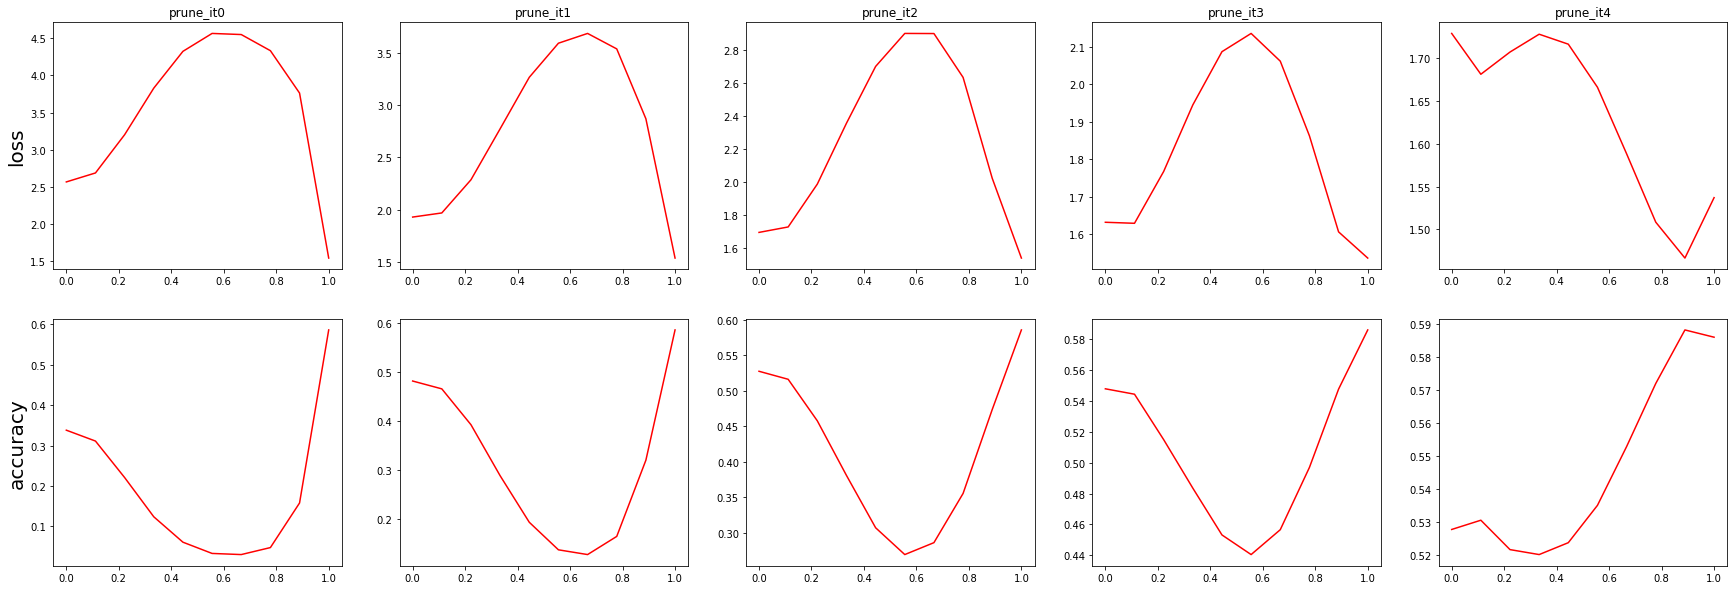

In [78]:
plot_losses_and_accuracies(5, loss_and_accuracy_for_plot)

#### pr0.99_sched0_lr0.03

In [88]:
#!g1.1
pruned = torch.load("models/pr0.99_sched1_lr0.03_iters10000/pruned").to(device)
directory = "models/pr0.99_sched1_lr0.03_iters10000"
loss_and_accuracy_for_plot = []
for i, filename in enumerate(os.listdir(directory)):
    if i == 5:
      break
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        model = torch.load(f).to(device)
        loss_and_accuracy_for_plot.append(get_losses_and_accuracies(10, pruned, model))

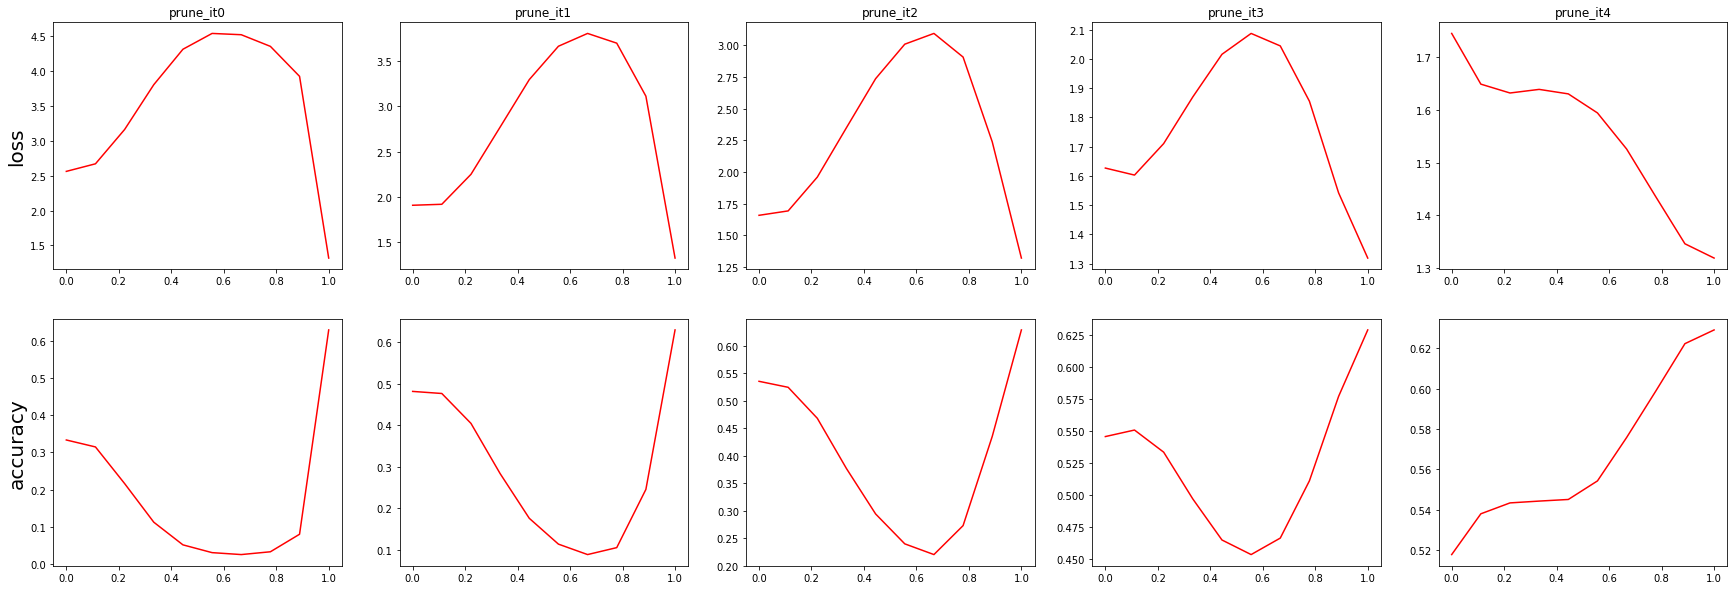

In [89]:
plot_losses_and_accuracies(5, loss_and_accuracy_for_plot)

#### pr0.99_sched1_lr0.03_pruned vs pr0.99_sched0_lr0.03_pruned

In [83]:
#!g1.1
sched = torch.load("models/pr0.99_sched1_lr0.03_iters10000/pruned")
simple = torch.load("models/pr0.99_sched0_lr0.03_iters10000/pruned")

losses_and_accuracies = get_losses_and_accuracies(10, sched, simple)

[Text(0.5, 1.0, 'accuracy')]

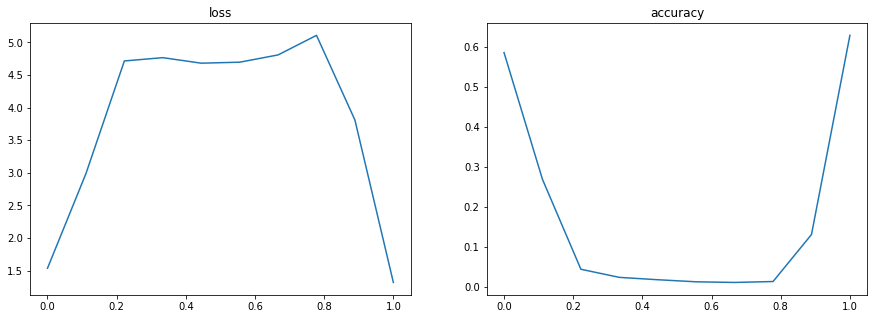

In [84]:
#!g1.1
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
x = [i for i, j, k in losses_and_accuracies]
y = [j for i, j, k in losses_and_accuracies]
axs[0].plot(x, y)
axs[0].set(title="loss")
x = [i for i, j, k in losses_and_accuracies]
y = [k for i, j, k in losses_and_accuracies]
axs[1].plot(x, y)
axs[1].set(title="accuracy")


#### pr0.99_sched0_lr0.03_pruned vs pr0_sched0_lr0.03

In [88]:
#!g1.1
base = torch.load("models/pr0_sched0_lr0.03_iters10000/pruned")
pruned = torch.load("models/pr0.99_sched0_lr0.03_iters10000/pruned")

losses_and_accuracies = get_losses_and_accuracies(10, pruned, base)

[Text(0.5, 1.0, 'accuracy')]

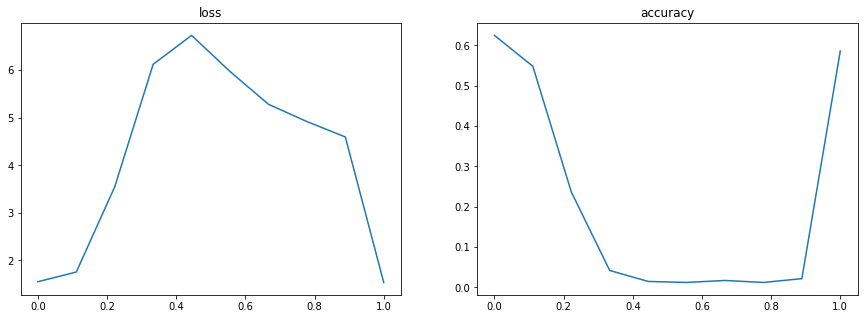

In [89]:
#!g1.1
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
x = [i for i, j, k in losses_and_accuracies]
y = [j for i, j, k in losses_and_accuracies]
axs[0].plot(x, y)
axs[0].set(title="loss")
x = [i for i, j, k in losses_and_accuracies]
y = [k for i, j, k in losses_and_accuracies]
axs[1].plot(x, y)
axs[1].set(title="accuracy")


#### pr0.99_sched0_lr0.03_pruned vs pr0_sched0_lr0.03

In [94]:
#!g1.1
base = torch.load("models/pr0_sched0_lr0.03_iters10000/pruned")
pruned = torch.load("models/pr0.99_sched1_lr0.03_iters10000/pruned")

losses_and_accuracies = get_losses_and_accuracies(10, pruned, base)

[Text(0.5, 1.0, 'accuracy')]

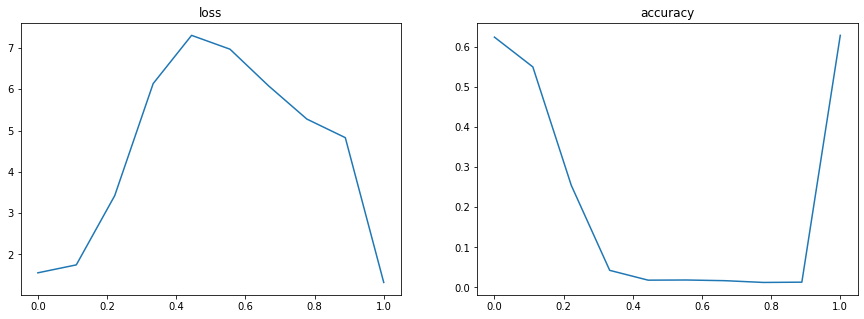

In [95]:
#!g1.1
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
x = [i for i, j, k in losses_and_accuracies]
y = [j for i, j, k in losses_and_accuracies]
axs[0].plot(x, y)
axs[0].set(title="loss")
x = [i for i, j, k in losses_and_accuracies]
y = [k for i, j, k in losses_and_accuracies]
axs[1].plot(x, y)
axs[1].set(title="accuracy")


### Сравнение последовательных шагов

#### Для модели без шедулера


#### pr0.99_sched0_lr0.03

In [96]:
#!g1.1
pruned = torch.load("models/pr0.99_sched0_lr0.03_iters10000/pruned").to(device)
directory = "models/pr0.99_sched0_lr0.03_iters10000"
loss_and_accuracy_for_plot = []
files = []
for i, filename in enumerate(os.listdir(directory)):
    if i == 5:
      break
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
      files.append(f)
for i in range(0, len(files) - 1):
    model1 = torch.load(files[i]).to(device)
    model2 = torch.load(files[i + 1]).to(device)
    loss_and_accuracy_for_plot.append(get_losses_and_accuracies(10, model2, model1))

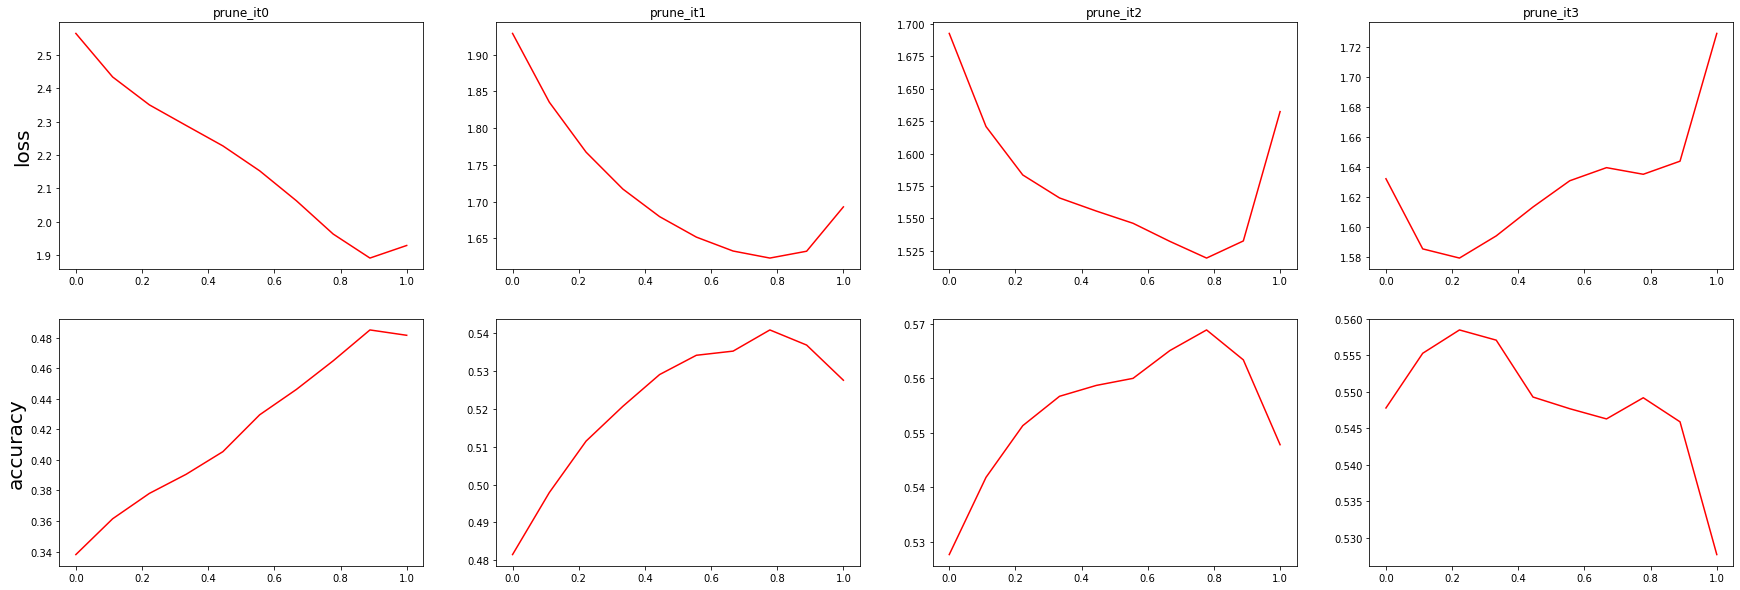

In [97]:
#!g1.1
plot_losses_and_accuracies(len(loss_and_accuracy_for_plot), loss_and_accuracy_for_plot) 
#   prune_it=0                                     prune_it=1  prune_it=1                             prune_it=2   prune_it=2                                 prune_it=3   prune_it=3                                    prune_it=4

#### pr0.99_sched1_lr0.03

In [105]:
#!g1.1
# 1 - 3, 2 - 4, 3 - 5
loss_and_accuracy_for_plot = []
for i in range(0, len(files) - 2):
    model1 = torch.load(files[i]).to(device)
    model2 = torch.load(files[i + 2]).to(device)
    loss_and_accuracy_for_plot.append(get_losses_and_accuracies(10, model2, model1))


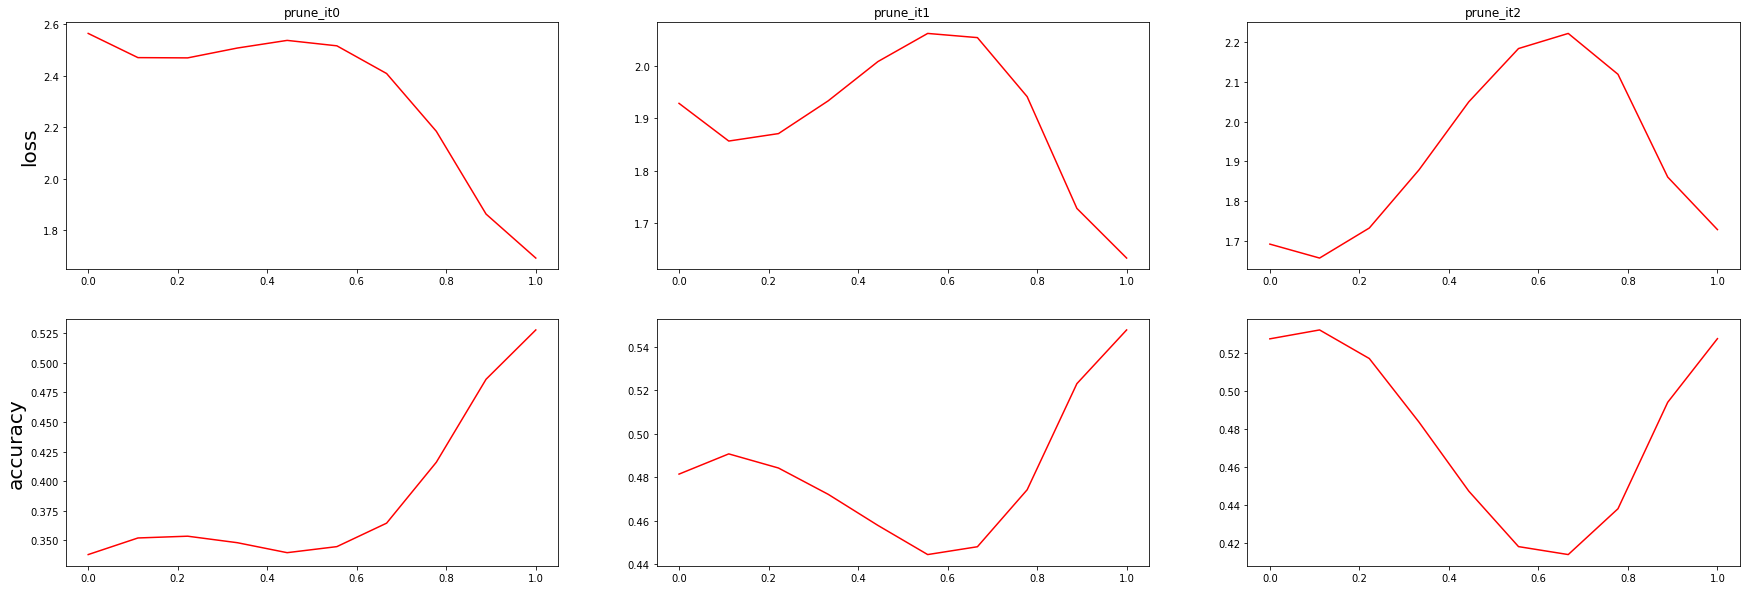

In [106]:
#!g1.1
plot_losses_and_accuracies(len(loss_and_accuracy_for_plot), loss_and_accuracy_for_plot) 
#   prune_it=0                                                  prune_it=2     prune_it=1                                                   prune_it=3  prune_it=2                                                      prune_it=4

In [107]:
#!g1.1
# 1 - 4, 2 - 5
loss_and_accuracy_for_plot = []
for i in range(0, len(files) - 3):
    model1 = torch.load(files[i]).to(device)
    model2 = torch.load(files[i + 3]).to(device)
    loss_and_accuracy_for_plot.append(get_losses_and_accuracies(10, model2, model1))

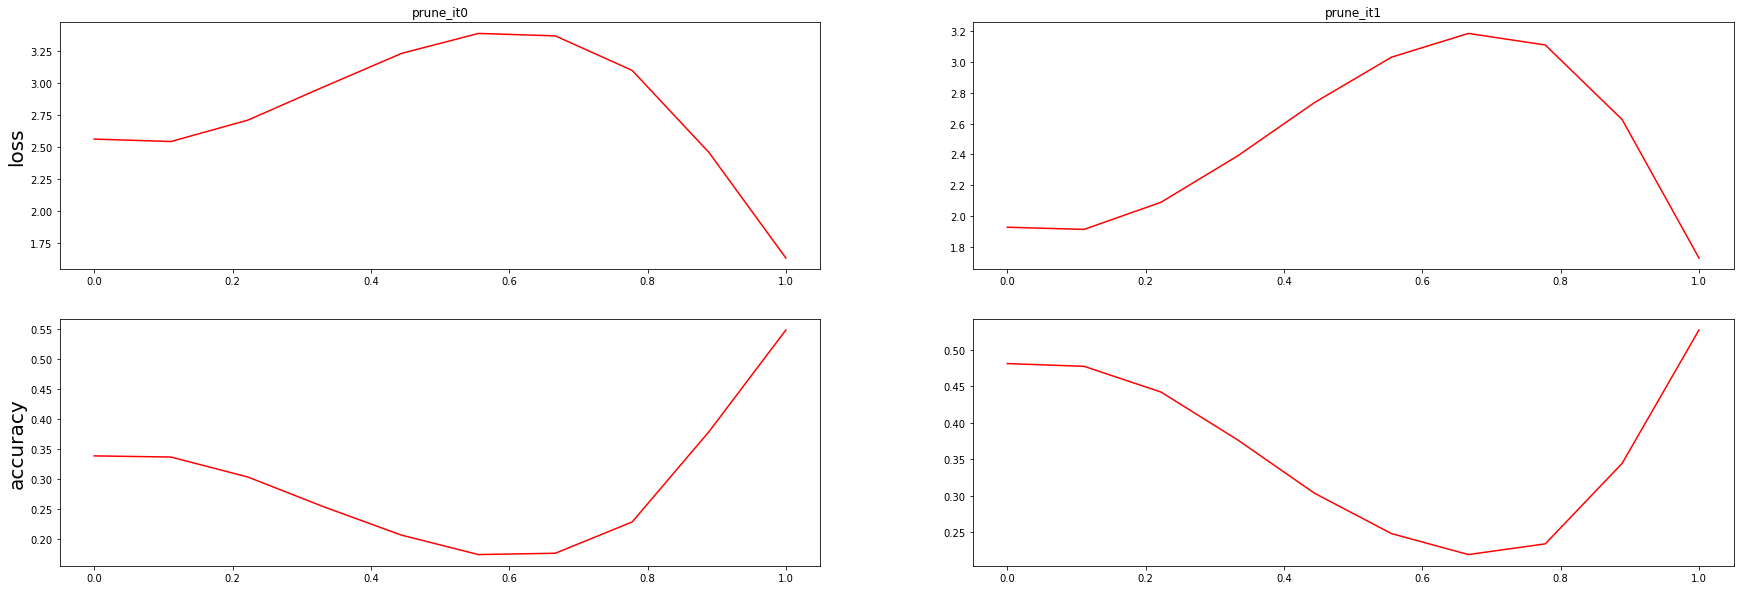

In [108]:
#!g1.1
plot_losses_and_accuracies(len(loss_and_accuracy_for_plot), loss_and_accuracy_for_plot) 
#   prune_it=0                                                                                     prune_it=3         prune_it=1                                                                                  prune_it=4

In [111]:
#!g1.1
# это буквально между 1 и 5, просто для красоты цикл оставил
loss_and_accuracy_for_plot = []
for i in range(0, len(files) - 4):
    model1 = torch.load(files[i]).to(device)
    model2 = torch.load(files[i + 4]).to(device)
    loss_and_accuracy_for_plot.append(get_losses_and_accuracies(10, model2, model1))

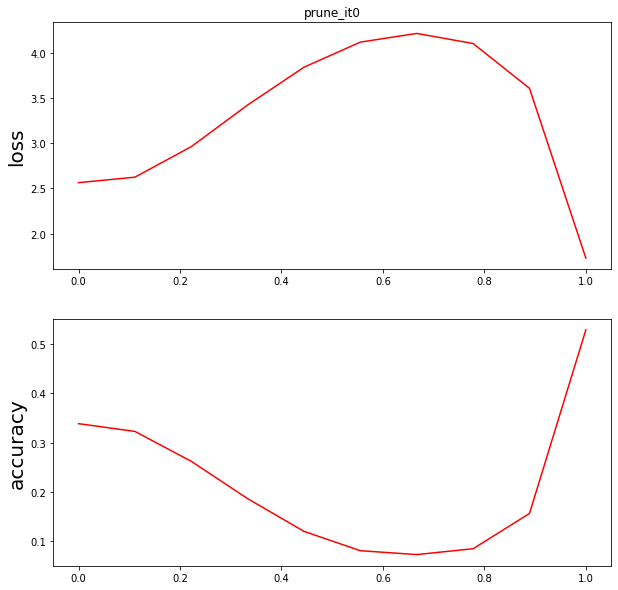

In [120]:
#!g1.1
# plot_losses_and_accuracies(len(loss_and_accuracy_for_plot), loss_and_accuracy_for_plot) 
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
  
for i in range(1):
    x = [p for p, j, k in loss_and_accuracy_for_plot[i]]
    y = [j for p, j, k in loss_and_accuracy_for_plot[i]]
    axs[0].plot(x, y, color="red", label="line")
    axs[0].set(title="prune_it" + str(i))
    axs[0].set_ylabel("loss", size=20)

for i in range(1):
    x = [p for p, j, k in loss_and_accuracy_for_plot[i]]
    y = [k for p, j, k in loss_and_accuracy_for_plot[i]]
    axs[1].plot(x, y, color="red", label="line")

axs[1].set_ylabel("accuracy", size=20)

plt.show()
#   prune_it=0                                                          prune_it=4

#### Для модели с шедулером



In [121]:
#!g1.1
pruned = torch.load("models/pr0.99_sched1_lr0.03_iters10000/pruned").to(device)
directory = "models/pr0.99_sched1_lr0.03_iters10000"
loss_and_accuracy_for_plot = []
files = []
for i, filename in enumerate(os.listdir(directory)):
    if i == 5:
      break
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
      files.append(f)
for i in range(0, len(files) - 1):
    model1 = torch.load(files[i]).to(device)
    model2 = torch.load(files[i + 1]).to(device)
    loss_and_accuracy_for_plot.append(get_losses_and_accuracies(10, model2, model1))

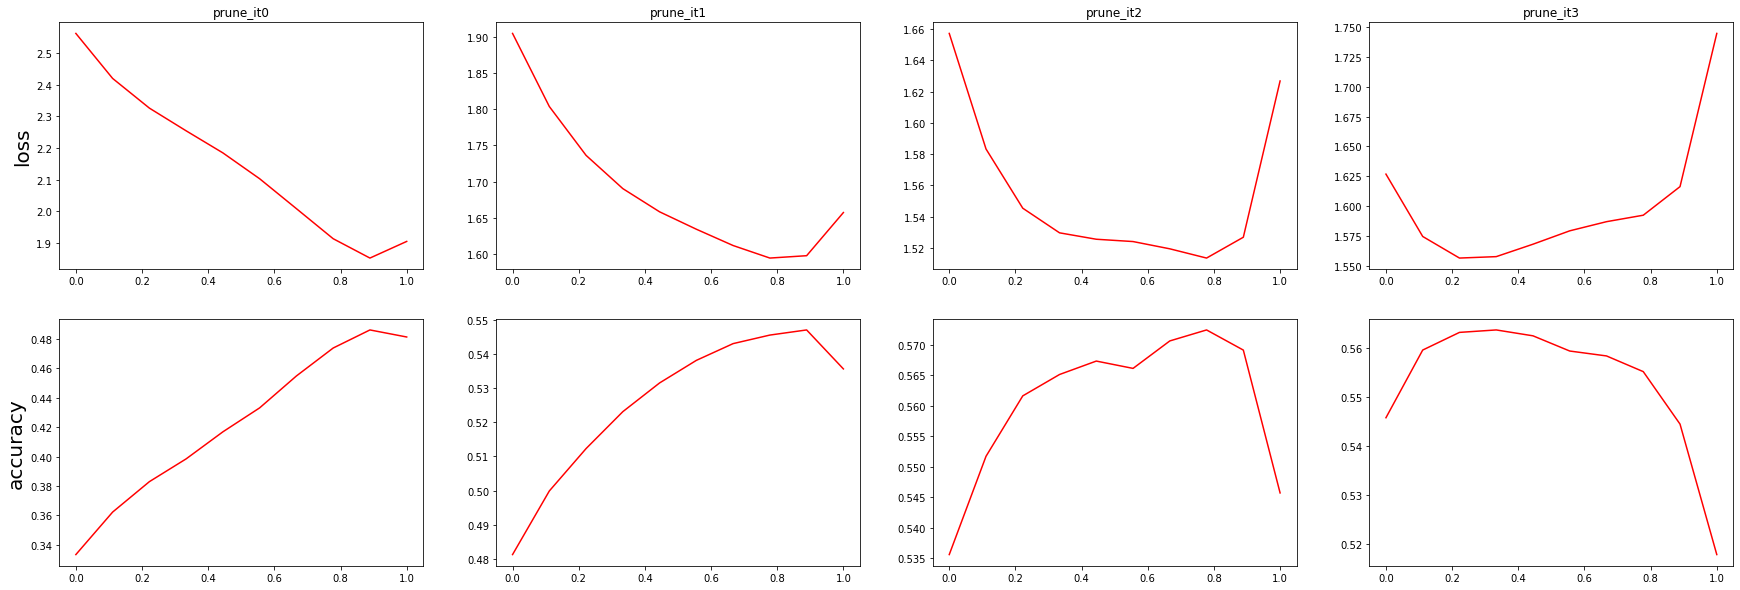

In [122]:
#!g1.1
plot_losses_and_accuracies(len(loss_and_accuracy_for_plot), loss_and_accuracy_for_plot) 
#   prune_it=0                                     prune_it=1  prune_it=1                             prune_it=2   prune_it=2                                 prune_it=3   prune_it=3                                    prune_it=4

#### pr0.99_sched1_lr0.03

In [123]:
#!g1.1
# 1 - 3, 2 - 4, 3 - 5
loss_and_accuracy_for_plot = []
for i in range(0, len(files) - 2):
    model1 = torch.load(files[i]).to(device)
    model2 = torch.load(files[i + 2]).to(device)
    loss_and_accuracy_for_plot.append(get_losses_and_accuracies(10, model2, model1))


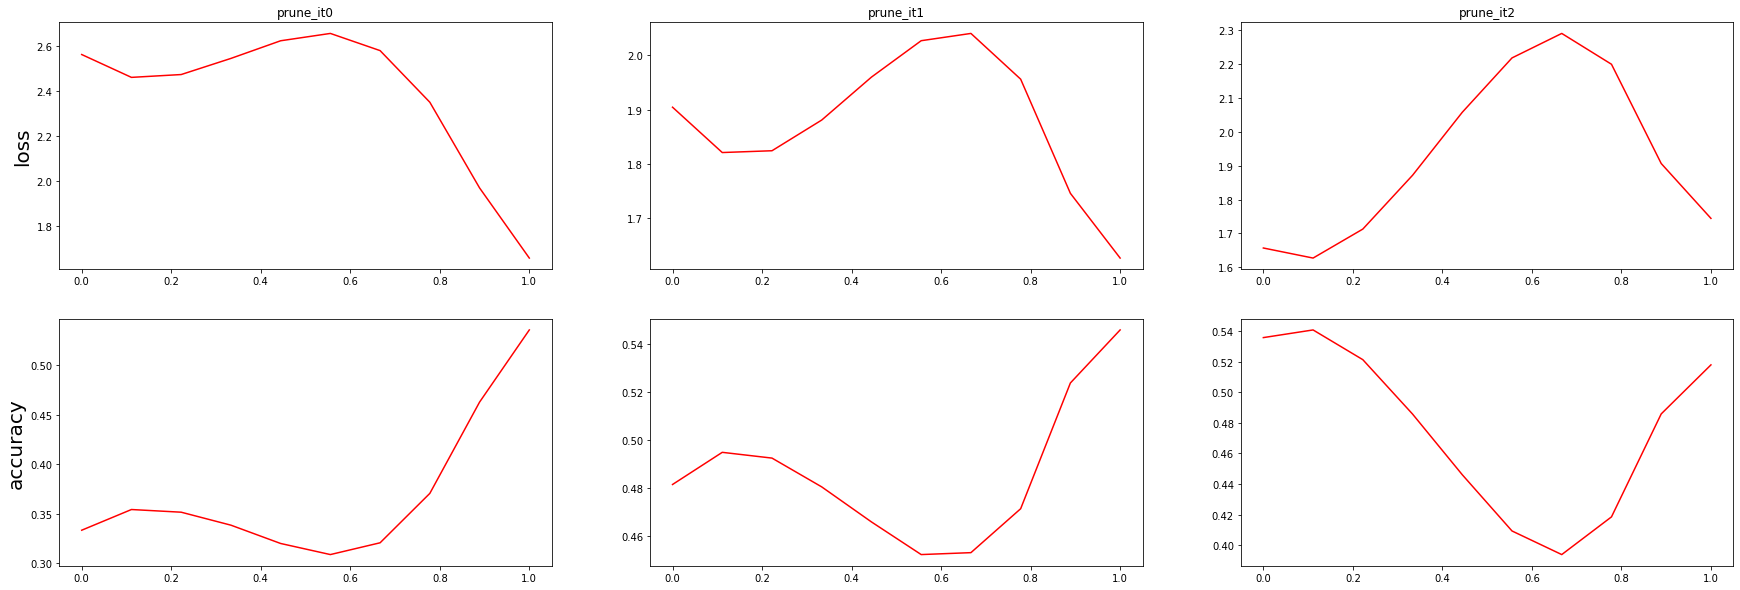

In [124]:
#!g1.1
plot_losses_and_accuracies(len(loss_and_accuracy_for_plot), loss_and_accuracy_for_plot) 
#   prune_it=0                                                  prune_it=2     prune_it=1                                                   prune_it=3  prune_it=2                                                      prune_it=4

In [125]:
#!g1.1
# 1 - 4, 2 - 5
loss_and_accuracy_for_plot = []
for i in range(0, len(files) - 3):
    model1 = torch.load(files[i]).to(device)
    model2 = torch.load(files[i + 3]).to(device)
    loss_and_accuracy_for_plot.append(get_losses_and_accuracies(10, model2, model1))

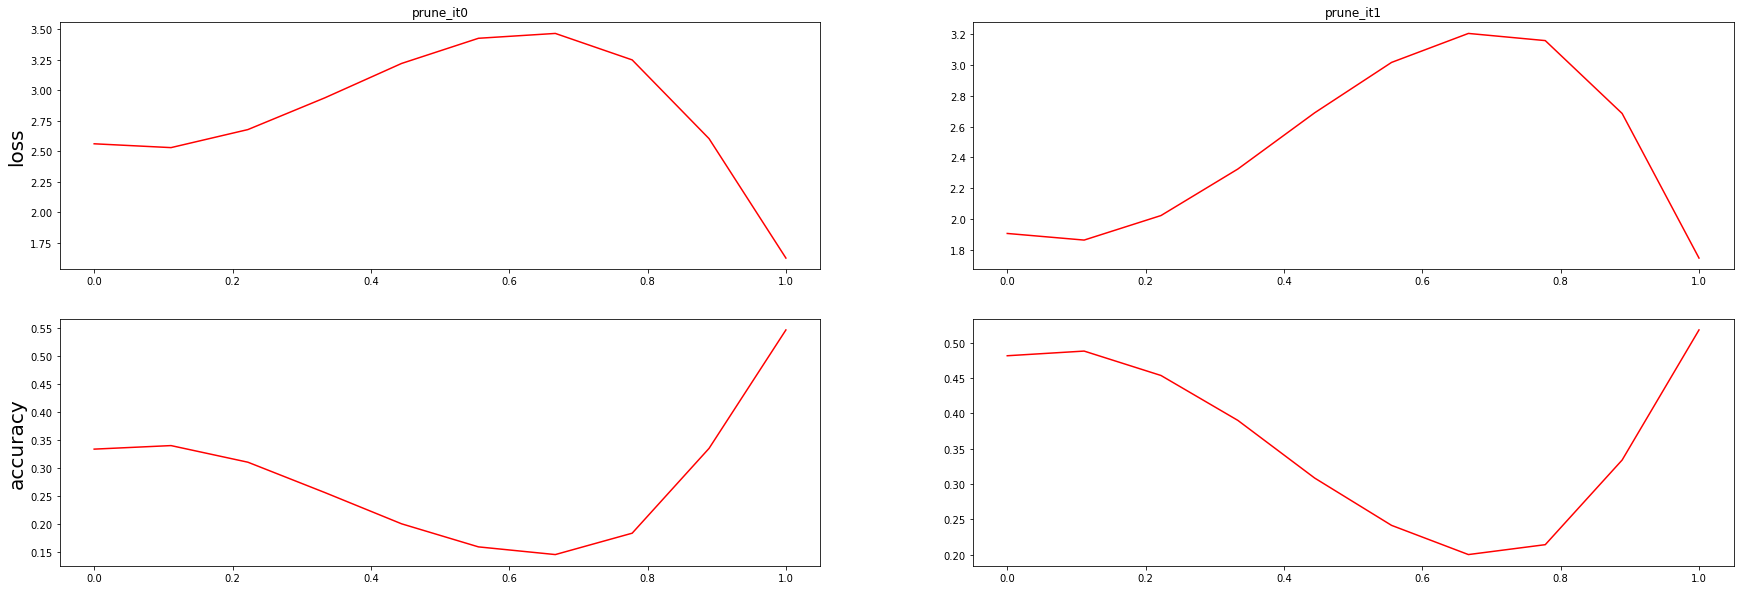

In [126]:
#!g1.1
plot_losses_and_accuracies(len(loss_and_accuracy_for_plot), loss_and_accuracy_for_plot) 
#   prune_it=0                                                                                     prune_it=3         prune_it=1                                                                                  prune_it=4

In [127]:
#!g1.1
# это буквально между 1 и 5, просто для красоты цикл оставил
loss_and_accuracy_for_plot = []
for i in range(0, len(files) - 4):
    model1 = torch.load(files[i]).to(device)
    model2 = torch.load(files[i + 4]).to(device)
    loss_and_accuracy_for_plot.append(get_losses_and_accuracies(10, model2, model1))

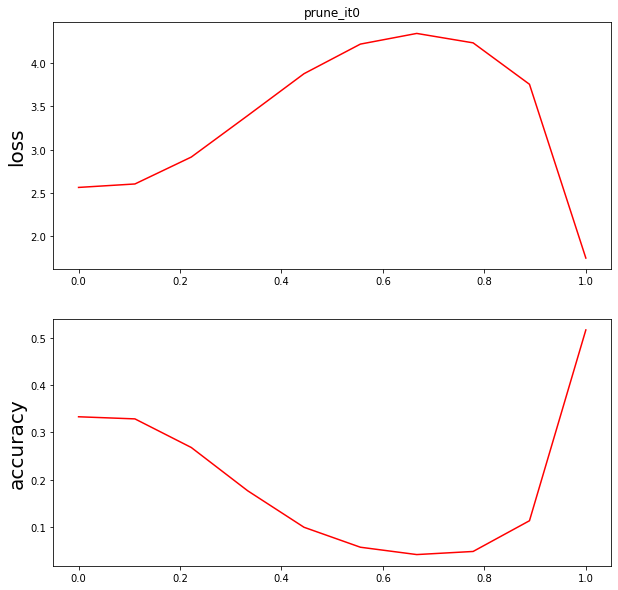

In [128]:
#!g1.1
# plot_losses_and_accuracies(len(loss_and_accuracy_for_plot), loss_and_accuracy_for_plot) 
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
  
for i in range(1):
    x = [p for p, j, k in loss_and_accuracy_for_plot[i]]
    y = [j for p, j, k in loss_and_accuracy_for_plot[i]]
    axs[0].plot(x, y, color="red", label="line")
    axs[0].set(title="prune_it" + str(i))
    axs[0].set_ylabel("loss", size=20)

for i in range(1):
    x = [p for p, j, k in loss_and_accuracy_for_plot[i]]
    y = [k for p, j, k in loss_and_accuracy_for_plot[i]]
    axs[1].plot(x, y, color="red", label="line")

axs[1].set_ylabel("accuracy", size=20)

plt.show()
#   prune_it=0                                                          prune_it=4

In [ ]:
#!g1.1
